<a href="https://colab.research.google.com/github/Harshilpatel2605/Single-Digit-Classification/blob/main/Single_Digit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check for Input Image :  9967.png


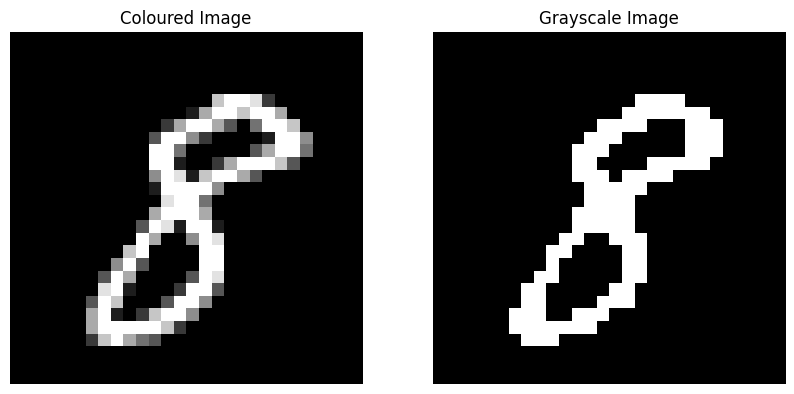

image size :  (28, 28)
Class Probabilities :  [[3.21789554e-44 1.40066777e-54 1.76452413e-36 4.78341566e-24
  3.17690571e-55 6.65078736e-14 9.02803119e-84 3.22839816e-64
  1.00000000e+00 7.00795765e-51]]
Predicted Digit: 8 with probability:  0.9999999999999334


In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Preprocessing for input image
threshold = 128  # To binarize the pixels

def image_to_array(image_path):
    """Convert an input image to a flattened binary array."""
    img_color = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)  # grayscale image.
    img_gray = cv2.GaussianBlur(img_gray, (3,3), 0)   # to reduce noise.
    _, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # size = 28*28 already.
    img_gray = (img_gray >= threshold).astype(int)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.title('Coloured Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_gray, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()

    # Convert to numpy array
    img_array = (img_binary > 128).astype(int)

    print("image size : ", img_array.shape)
    return img_array.flatten()  # Flatten (28x28 → 784,)


def load_mnist():
    """Load the MNIST dataset from OpenML."""
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist.data, mnist.target.astype(int)
    return X, y

def binarize(X):
    """Convert grayscale pixel values to binary (0 or 1)."""
    return (X >= threshold).astype(int)

def naiveBayes(X_train, y_train, smoothing=1):
    """Train Bernoulli Naive Bayes model."""
    k = 10  # Classes (0-9)
    features = X_train.shape[1]  # 784 pixels

    # Compute class priors
    class_counts = np.bincount(y_train, minlength=k)
    priors = class_counts / len(y_train)

    # Compute likelihoods using proper indexing
    feature_counts = np.zeros((k, features))

    for i in range(k):
        feature_counts[i] = np.sum(X_train[y_train == i], axis=0)  # Count occurrences per feature per class

    # Apply Laplace Smoothing
    likelihoods = (feature_counts + smoothing) / (class_counts[:, np.newaxis] + 2 * smoothing)

    return priors, likelihoods


# Predict using Naive Bayes
# def predict(X_test, priors, likelihoods):
#     log_priors = np.log(priors)  # Convert priors to log-space
#     log_likelihoods = np.log(likelihoods)  # Convert likelihoods to log-space
#     log_inv_likelihoods = np.log(1 - likelihoods)  # Log of (1 - P(X | Y))

#     log_posteriors = log_priors + np.dot(X_test, log_likelihoods.T) + np.dot(1 - X_test, log_inv_likelihoods.T)

#     return np.argmax(log_posteriors, axis=1)  # Directly return class index

def predict(X_test, priors, likelihoods):
    log_priors = np.log(priors)  # Convert priors to log-space
    log_likelihoods = np.log(likelihoods)  # Convert likelihoods to log-space
    log_inv_likelihoods = np.log(1 - likelihoods)  # Log of (1 - P(X | Y))

    predictions = []
    for x in X_test:  # Iterate over each test image
        # Compute log-probability for each class (digit 0-9)
        log_posteriors = log_priors + np.sum(log_likelihoods * x + log_inv_likelihoods * (1 - x), axis=1)

        # Convert back to probability space using exp
        posteriors = np.exp(log_posteriors - np.max(log_posteriors))  # Prevent overflow
        posteriors /= np.sum(posteriors)  # Normalize to get probabilities

        predictions.append(posteriors)  # Store probability vector

    return np.array(predictions)  # Returns shape (num_samples, 10)

def main():
    """Main function to train and test Bernoulli Naive Bayes."""
    X, y = load_mnist()
    X = binarize(X)
    y = y.astype(int)

    # Train model
    priors, likelihoods = naiveBayes(X, y, smoothing=1)

    # Test on input image
    imagePath = '9967.png'  # Replace with user input
    print("Check for Input Image : ", imagePath)
    x_test = image_to_array(imagePath).reshape(1, -1)

    y_pred = predict(x_test, priors, likelihoods)

    # Prediction output
    print("Class Probabilities : ", y_pred)
    pred = np.argmax(y_pred[0])
    print("Predicted Digit:", pred, "with probability: ", y_pred[0][pred])

main()
